# Comparison of regression models in predicting next-day stock returns

In [789]:
import pandas as pd
import numpy as np
from pathlib import Path
from datetime import date, datetime, timedelta
import os
from newsapi.newsapi_client import NewsApiClient
import alpaca_trade_api as tradeapi
import matplotlib.pyplot as plt
import hvplot.pandas
from joblib import dump, load

In [790]:
# Set News API Key
newsapi = NewsApiClient(api_key=os.getenv("NEWS_API_KEY"))

# Set Alpaca API key and secret
alpaca_api_key = os.getenv("ALPACA_API_KEY_ID")
alpaca_secret_key = os.getenv("ALPACA_SECRET_KEY")

api = tradeapi.REST(alpaca_api_key, alpaca_secret_key, api_version='v2')

In [791]:
# TODO
# Selecting the tickers can be a stand-alone function
# Set the ticker
tickers = ["AAPL", "AMZN", "GOOGL", "NFLX"]

# Set timeframe to '1D'
timeframe = '1D'

# Get current date and the date from one month ago
current_date = date.today()
past_date = date.today() - timedelta(weeks=4)

df = pd.DataFrame()

# Get historical data for AAPL
for tick in tickers:
    tmp_df = api.get_barset(
        tick,
        timeframe,
        limit=1000,
        start=current_date,
        end=past_date,
        after=None,
        until=None,
    ).df
    tmp_df = tmp_df.droplevel(0, axis=1)
    tmp_df.drop(columns=['open', 'high', 'low', 'volume'], inplace=True)
    tmp_df.rename({'close': tick}, axis=1, inplace=True)
    df = pd.concat([df, tmp_df], axis=1)
    
df.index = df.index.date

# df.head()
len(df)

1000

In [792]:
print(df.head())
print(df.tail())

             AAPL    AMZN   GOOGL     NFLX
2016-07-14  98.79  741.19  735.78  98.0200
2016-07-15  98.76  735.43  735.64  98.3900
2016-07-18  99.83  736.07  753.42  98.8037
2016-07-19  99.87  740.06  753.41  85.8300
2016-07-20  99.93  745.72  757.08  87.9200
              AAPL     AMZN    GOOGL    NFLX
2020-06-26  353.69  2692.87  1362.14  443.39
2020-06-29  362.00  2681.52  1398.00  447.42
2020-06-30  364.60  2756.09  1417.92  454.75
2020-07-01  364.01  2879.20  1442.60  485.58
2020-07-02  364.12  2887.56  1469.80  477.22


### Create stock df

In [793]:
stock_df = df['GOOGL'].to_frame()
stock_df.index = pd.to_datetime(stock_df.index)
stock_df.rename(columns={'GOOGL': 'close'}, inplace=True)
stock_df.dropna(inplace=True)

In [794]:
stock_df.head()

,close
2016-07-14,735.78
2016-07-15,735.64
2016-07-18,753.42
2016-07-19,753.41
2016-07-20,757.08


### Prep data for model fitting

In [795]:
# Split data by time segments of size `window` days
def window_data(stock_df, window, feature_col_num, target_col_num):
    X = []
    y = []
    
    for i in range(len(stock_df) - window):
        X_comp = stock_df.iloc[i:(i+window), feature_col_num]
        y_comp = stock_df.iloc[(i+window), target_col_num]
        X.append(X_comp)
        y.append(y_comp)
    return np.array(X), np.array(y).reshape(-1, 1)

In [796]:
window_size = 2
X, y = window_data(stock_df, window_size, 0, 0)

In [797]:
print(X[0])
print(y[0])

[735.78 735.64]
[753.42]


In [798]:
# Train/test split
train_size = 0.70
split = int(len(X) * train_size)

X_train = X[:split]
X_test = X[split:]

y_train = y[:split]
y_test = y[split:]

In [799]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()

scaler.fit(X)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

scaler.fit(y)
y_train = scaler.transform(y_train)
y_test = scaler.transform(y_test)

In [800]:
# Reshape the features for the model
# YOUR CODE HERE!
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

In [801]:
print(X_train[0])
print(X_test[0])
print(y_train[0])
print(y_test[0])

[[0.00017739]
 [0.        ]]
[[0.66446201]
 [0.67368608]]
[0.00027214]
[0.67899491]


In [802]:
X_train.shape

(698, 2, 1)

In [803]:
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, LSTM, Dropout

In [804]:
# Construct model

def create_model():

    model = Sequential()

    num_inputs = window_size
    dropout_fraction = 0.2

    # Layer 1
    model.add(LSTM(
        units=num_inputs,
        return_sequences=True,
        input_shape=(X_train.shape[1], 1)
    ))
    model.add(Dropout(dropout_fraction))

    # Layer 2
    model.add(LSTM(
        units=num_inputs,
        return_sequences=True
    ))
    model.add(Dropout(dropout_fraction))

    # Layer 3
    model.add(LSTM(
        units=num_inputs
    ))
    model.add(Dropout(dropout_fraction))

    # Output layer
    model.add(Dense(1))

    model.compile(optimizer='adam', loss='mean_squared_error')
    
    return model

model = create_model()

In [805]:
X_train.shape

(698, 2, 1)

In [806]:
# Compile model
model.compile(optimizer='adam', loss='mean_squared_error')

In [807]:
# Summary
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_60 (LSTM)               (None, 2, 2)              32        
_________________________________________________________________
dropout_60 (Dropout)         (None, 2, 2)              0         
_________________________________________________________________
lstm_61 (LSTM)               (None, 2, 2)              40        
_________________________________________________________________
dropout_61 (Dropout)         (None, 2, 2)              0         
_________________________________________________________________
lstm_62 (LSTM)               (None, 2)                 40        
_________________________________________________________________
dropout_62 (Dropout)         (None, 2)                 0         
_________________________________________________________________
dense_20 (Dense)             (None, 1)                 3         
Total para

In [808]:
# Fit model
model.fit(X_train, y_train, batch_size=2, epochs=10, shuffle=False, verbose=1)

Epoch 1/10
698/698 [==============================] - 24s 34ms/sample - loss: 0.0113
Epoch 2/10
698/698 [==============================] - 8s 11ms/sample - loss: 0.0267
Epoch 3/10
698/698 [==============================] - 5s 7ms/sample - loss: 0.0261
Epoch 4/10
698/698 [==============================] - 5s 7ms/sample - loss: 0.0233
Epoch 5/10
698/698 [==============================] - 5s 7ms/sample - loss: 0.0190
Epoch 6/10
698/698 [==============================] - 5s 7ms/sample - loss: 0.0169
Epoch 7/10
698/698 [==============================] - 5s 7ms/sample - loss: 0.0127
Epoch 8/10
698/698 [==============================] - 5s 7ms/sample - loss: 0.0117
Epoch 9/10
698/698 [==============================] - 5s 6ms/sample - loss: 0.0093
Epoch 10/10
698/698 [==============================] - 5s 7ms/sample - loss: 0.0088


In [809]:
# Evaluate model
model.evaluate(X_test, y_test)

300/300 [==============================] - 5s 18ms/sample - loss: 0.0205


0.02053722981363535

In [810]:
print(f"X_test: {X_test[0]}")
print(f"y_test: {y_test[0]}")

X_test: [[0.66446201]
 [0.67368608]]
y_test: [0.67899491]


In [811]:
predicted = model.predict(X_test)

# Inverse scale
real_prices = scaler.inverse_transform(y_test.reshape(-1, 1))
predicted_prices = scaler.inverse_transform(predicted)

predictions = pd.DataFrame({
    'Real': real_prices.ravel(),
    'Predicted': predicted_prices.ravel()
})

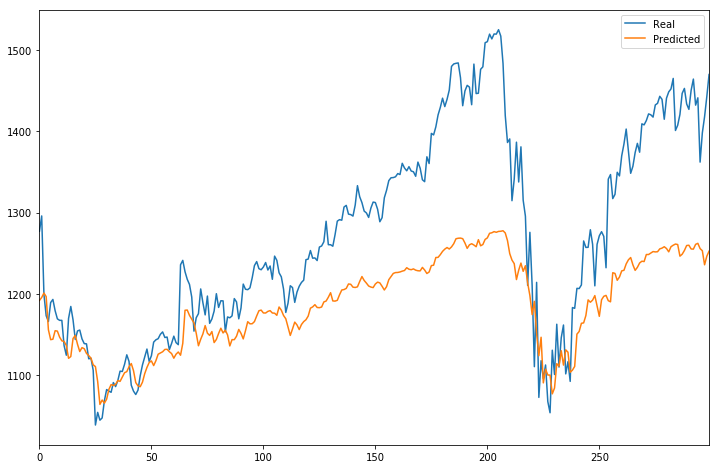

In [812]:
predictions.plot(figsize=(12,8))

In [826]:
model.save('./Models/GOOGL_model')
g_model = load_model('./Models/GOOGL_model')

In [827]:
g_model.evaluate(X_test, y_test)

300/300 [==============================] - 5s 18ms/sample - loss: 0.0205


0.02053722981363535

In [828]:
# Showing that g_model gives same output
model.evaluate(X_test, y_test)

300/300 [==============================] - 0s 239us/sample - loss: 0.0205


0.02053722981363535

In [ ]:
l = predicted_return(g_model, stock_df, window=5, fit_window=2)
l

In [829]:
def predicted_portfolio_metrics(model, all_data, window=30, fit_window=5, have_today_close=False):
    '''
    Uses `model` to predict returns `window` days in the future.
    
    Need `fit_window` (some num of days) so we know what to 
    pass in to model.fit() (via `get_prediction`).
    
    Expect `window` from user, but default to 30. This is the holding
    window, i.e. how far out we want to predict.
    
    Assumes model is current (i.e. has been fitted on data up to 
    yesterday or, if there is a closing price, today.
    
    Need `have_today_close` because we need to know whether the 
    model was fitted with data for today or only up to yesterday.
    '''
    
    # DF where we'll append predictions as we generate them. Copying 
    # most recent `training_window` days from all_data so that we 
    # have a basis for predictions.
    df = all_data.iloc[-fit_window:].copy()

    for _ in range(window):        
        # Scale data and reshape for model
        #
        # Still using fit_window here because we only want
        # most recent fit_window days for making prediction
        data = prep_data_for_pred(df.iloc[-fit_window:], all_data, fit_window)
        
        # Get prediction
        pred = model.predict(data)
        
        # Inverse transform and reshape predicted price
        pred = rescale_pred(pred, all_data)
        pred = pred.reshape(-1,)
        
        # Get date for adding new row to index
        pred_date = df.iloc[-1].name + timedelta(days=1)
        
        # Add predictions to df
        df = df.append(pd.DataFrame({'close': pred}, index=[pred_date]))
        
        # Fit model with added data (predictions)
        X, y = prep_data_for_fitting(df, fit_window)
        model.fit(X, y, epochs=10, shuffle=False, batch_size=1, verbose=0)
        
    # After for loop, last row in df should be the prediction 
    # that we want.
    pred_to_return = df.iloc[-1]
    
    # TODO
    # Calculate pred_return, sharpe ratio, date of prediction (just to 
    # be transparent for user)
    #
    # What info do we need to calc return? User's exising investment?
    # What date do we start with? Today's date?
    df['return'] = df['close'].pct_change()
    pred_return = df.iloc[-1]['return'] * 100
    
    sharpe_ratio = (df['return'].mean() * 252) / (df['return'].std() * np.sqrt(252))
    
    prediction_date = df.iloc[-1].name.date()
    
    return pred_return, sharpe_ratio, prediction_date

In [830]:
def get_prediction(data, model):
    # TODO
    # df.loc[pred_date] = model.predict()
    pred = model.predict(data)
    return pred

In [831]:
def prep_data_for_fitting(df, fit_window):
    '''
    Create data using `window_data`.
    Scale data.
    Return X, y for fitting model.
    '''
    X, y = window_data(df, fit_window, 0, 0)
    
    scaler = MinMaxScaler()
    scaler.fit(X)
    X = scaler.transform(X)
    
    X = X.reshape((X.shape[0], X.shape[1], 1))
    
    scaler.fit(y)
    y = scaler.transform(y)
    
    return X, y

In [832]:
def update_model(model):
    '''
    Fits model with most current data.
    '''
    # TODO
    pass

In [833]:
def prep_data_for_pred(data, stock_data, fit_window):
    '''
    Prep data for prediction.
    
    `stock_data` is need to fit the scaler to ALL of the data.
    '''
    X = np.array(data)
    
    scaler = MinMaxScaler()
    scaler.fit(stock_data)
    X = scaler.transform(X)
    
    # Reshape for model
    # Not sure how to set this programmatically (e.g. using
    # X.shape[0], X.shape[1], etc.) but this works.
    X = X.reshape((1, fit_window, 1))
    
    return X

In [834]:
def rescale_pred(pred, stock_data):
    '''
    Inversely scale data.
    '''
    scaler = MinMaxScaler()
    scaler.fit(stock_data)
    pred = scaler.inverse_transform(pred)
    return pred

In [835]:
datetime.today().date().strftime('%d-%m-%Y')

'05-07-2020'

In [836]:
class myNN(Sequential):
    def __init__(self):
        super(Sequential, self).__init__()

In [ ]:
model.fit()

In [842]:
stock_df.iloc[-1].name

Timestamp('2020-07-02 00:00:00')